# Logistic Regression CUDA Demonstration

For this demo, we will compare the functionality of our CUDA-based LogisticRegression (called `LogReg`) to a numpy-based LogisticRegression (called `PyLogReg`)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ctypes import *
%matplotlib inline

In [2]:
from classifiers import LogisticRegression as LogReg
from classifiers import PyLogisticRegression as PyLogReg

### Based on the House Prices Kaggle dataset.

This isn't a likely appliciation for a Logistic Regression but we chose it anyway since the dataset is entirely numeric allowing us to manipulate it easily for use with our C-based implementation. We are changing the label `y` to be `True` if `price[i] > price.mean()`

In [3]:
df = pd.read_csv('house_data.csv')

In [4]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,yr_built
0,221900.0,3,1.00,1180,5650,1.0,3,7,1955
1,538000.0,3,2.25,2570,7242,2.0,3,7,1951
2,180000.0,2,1.00,770,10000,1.0,3,6,1933
3,604000.0,4,3.00,1960,5000,1.0,5,7,1965
4,510000.0,3,2.00,1680,8080,1.0,3,8,1987


### Separating observations and labels

Extremely important note: We learned the hard way that Pandas stores its values in column-major ordering, but numpy uses row-major. Furthermore, the underlying memory is not contiguous until you call `copy()`, thus making it nearly impossible to use with C without extra legwork.

In [5]:
y = (df['price'] > df['price'].mean()).astype('float64').copy()
X = df.loc[:,'bedrooms':].astype('float64').copy()

### Calling our Numpy-based implementation to establish a baseline for coefficients

In [6]:
logit = PyLogReg(num_iter=100, fit_intercept=False)

In [7]:
logit.fit(X.values, y.values)

/home/oupton/git/CUDA_Stats/logreg/classifiers.py:19: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


In [8]:
logit.theta

array([-1.33800637e-01,  4.09142849e-03,  6.57718073e+01,  3.35666405e+01,
       -1.45910210e-02, -2.16409010e-01, -2.01157337e-01, -1.28157098e+02])

In [9]:
np_yt = logit.predict(X.values, threshold=0.5)

### Now calling our CUDA-based implementation to compare

In [10]:
logit = LogReg(n_iter=100)

In [11]:
logit.fit(X.values.copy(), y.values.copy())

In [12]:
logit.theta

array([-1.33800637e-01,  4.09142849e-03,  6.57718073e+01,  3.35666405e+01,
       -1.45910210e-02, -2.16409010e-01, -2.01157337e-01, -1.28157098e+02])

In [13]:
cuda_yt = logit.predict(X.values.copy())

### Great! Looks like we are getting the correct coefficients from our CUDA-based implementation

In [14]:
np.sum(cuda_yt == np_yt) == cuda_yt.shape[0]

True

### Here is our loop that implements the logistic regression
```c
for (size_t i = 0; i < n_iter; i++) {

    // dot(X, theta)
    vec_dot_mat<<<GRIDSIZE(m), BLOCKSIZE>>>(Xd, thetad, z, m, n);

    // h = sigm(z)
    vec_sigmoid<<<GRIDSIZE(m), BLOCKSIZE>>>(z, h, 1, m);

    // h = -h
    vec_scalar_mul<<<GRIDSIZE(m), BLOCKSIZE>>>(h, h, -1.0, 1, m);

    // h = y - h
    vec_add<<<GRIDSIZE(m), BLOCKSIZE>>>(h, yd, h, 1, m);

    // h = -(y - h) = h - y
    vec_scalar_mul<<<GRIDSIZE(m), BLOCKSIZE>>>(h, h, -1.0, 1, m); 

    // g = dot(Xt, h)
    vec_dot_mat<<<GRIDSIZE(n), BLOCKSIZE>>>(Xt, h, g, n, m);

    // g = -(g*lr) / m
    vec_scalar_mul<<<GRIDSIZE(n), BLOCKSIZE>>>(g, g, -(lr / m), 1, n);

    // theta = theta + (-g) = theta - g
    vec_add<<<GRIDSIZE(n), BLOCKSIZE>>>(thetad, g, thetad, 1, n);
}
```

### Here is our Python class used to call into CUDA
```py
import numpy as np
import ctypes
from ctypes import *

LIBPATH = './log_reg.so'

class LogisticRegression:
    def __init__(self, lr=0.01, n_iter=100000, fit_intercept=True, verbose=False):
        self.lr = lr
        self.n_iter = n_iter
        self.fit_intercept = fit_intercept
        self.verbose = verbose
        self.lib = ctypes.CDLL(LIBPATH, mode=ctypes.RTLD_GLOBAL)
    
    def fit(self, X, y):
        assert X.shape[0] == y.shape[0], "Dimensions do not match"
        if not hasattr(self, 'theta'):
            self.theta = np.zeros(X.shape[1])
        func = self.lib.fit
        func.argtypes = [POINTER(c_double), POINTER(c_double), POINTER(c_double), c_double, c_size_t, c_size_t, c_size_t, c_bool]

        Xp = X.ctypes.data_as(POINTER(c_double))
        yp = y.ctypes.data_as(POINTER(c_double))
        thetap = self.theta.ctypes.data_as(POINTER(c_double))

        func(Xp, yp, thetap, self.lr, X.shape[0], X.shape[1], self.n_iter, False)

    def predict_prob(self, X):
        assert X.shape[1] == self.theta.shape[0], "Dimensions do not match"
        func = self.lib.predict_proba
        func.argtypes = [POINTER(c_double), POINTER(c_double), POINTER(c_double), c_size_t, c_size_t]

        y = np.zeros(X.shape[0]).astype('float64')

        Xp = X.ctypes.data_as(POINTER(c_double))
        yp = y.ctypes.data_as(POINTER(c_double))
        thetap = self.theta.ctypes.data_as(POINTER(c_double))
        func(Xp, thetap, yp, X.shape[0], X.shape[1])
        return y
    
    def predict(self, X, threshold=0.5):
        return self.predict_prob(X) >= threshold
```

### Time analysis data from C executable

In [22]:
from scipy import stats

In [23]:
df = pd.read_csv('timedata.csv')

In [24]:
x = df['m']
y = df['cpu_time']

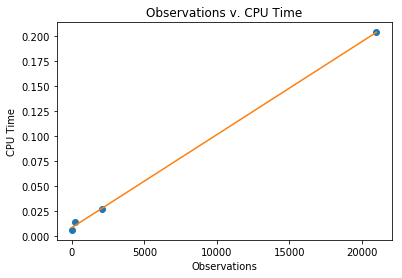

In [26]:
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
line = slope*x + intercept

plt.plot(x, y,'o', x, line)
plt.title('Observations v. CPU Time')
plt.xlabel('Observations')
plt.ylabel('CPU Time')
plt.show()

In [28]:
print('Correlation Coefficient:', r_value)

Correlation Coefficient: 0.9996554362784382


### Perfectly linear! Sequentially, this would be an O(n^2) problem